Burada "project_directory" değişkeninin kendi uzantınıza göre değiştirmeniz gerekiyor.

In [1]:
project_directory ='D:\\proje\\'

# **YÜKLE**

Dizinleri yukleyebilirsiniz

In [2]:
import numpy as np
# Numpy dizilerini yükle
X_train = np.load(project_directory+'\dizinler\X_train.npy')
y_train = np.load(project_directory+'\dizinler\y_train.npy')
X_val = np.load(project_directory+'\dizinler\X_val.npy')
y_val = np.load(project_directory+'\dizinler\y_val.npy')
X_test = np.load(project_directory+'\dizinler\X_test.npy')
y_test = np.load(project_directory+'\dizinler\y_test.npy')

Modelleri Yükleyebilirsiniz

In [3]:
from tensorflow.keras.models import load_model
# Modelinizi yükleyin
cnn_model = load_model(project_directory+"\\model\\modelCNN.h5")

In [4]:
from tensorflow.keras.models import load_model
# Modelinizi yükleyin
lenet_model = load_model(project_directory+"\\model\\lenet_model.h5")

In [5]:
from tensorflow.keras.models import load_model
# Modelinizi yükleyin
GoogLenet_model = load_model(project_directory+"\\model\\inception_model.h5")

In [6]:
from tensorflow.keras.models import load_model
# Modelinizi yükleyin
densenet_model = load_model(project_directory+"\\model\\densenet_model.h5")

In [7]:
from tensorflow.keras.models import load_model
# Modelinizi yükleyin
EfficientNetB0_model = load_model(project_directory+"\\model\\EfficientNetB0_model.h5")

# **VERİ ÖN İŞLEME VE VERİ SETİNİ BÖLME**

In [32]:
import pandas as pd
# CSV dosyasını oku
csv_file_path = (project_directory+r"\annotations.csv")
df = pd.read_csv(csv_file_path)

# HLY sütunundan dosya adlarını ve etiketleri al
file_names = df['HLY']
label = df['tissue type']

# Görüntülerin bulunduğu dizin
source_directory = project_directory+r"\dataset"

In [13]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
# Görüntüleri yükleyip diziye dönüştürme işlemi
def process_images(df, source_directory):
    images = []
    labels = []

    for index, row in df.iterrows():
        image_name = row['HLY']  # HLY sütunundaki görüntü adı
        label = row['tissue type']  # Etiket değeri
        image_path = os.path.join(source_directory, str(image_name))
        # Eğer görüntü dosyası bulunamaz ise
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")#Uyarı mesajı 
            continue
        # Görüntüyü yükle ve diziye dönüştür
        #Boyutunu 200*200 yap 
        img = load_img(image_path, target_size=(200, 200))
        img_array = img_to_array(img)

        images.append(img_array)
        labels.append(label)
    return images, labels

# Etiketlere göre veriyi orantılı olarak böler
def split_data_by_labels(df, test_size=0.2, val_size=0.1, random_state=42):
    # Etiketlere göre veriyi bölecek şekilde rastgele örnekler seçerek
    train_df, test_val_df = train_test_split(df, test_size=(val_size + test_size), stratify=df['tissue type'], random_state=random_state)

    # Kalan veriyi train ve validation olarak böl
    val_df, test_df = train_test_split(test_val_df, test_size=(test_size / (val_size + test_size)), stratify=test_val_df['tissue type'], random_state=random_state)

    return train_df, val_df, test_df

# Veriyi etiketlere göre orantılı olarak bölme
train_df, val_df, test_df = split_data_by_labels(df, test_size=0.2, val_size=0.1, random_state=42)

# Train, validation ve test setlerini oluşturun
X_train, y_train = process_images(train_df, source_directory)
X_val, y_val = process_images(val_df, source_directory)
X_test, y_test = process_images(test_df, source_directory)

In [ ]:
# Numpy dizilerini kaydet
np.save(project_directory+'\dizinler\X_train.npy', X_train)
np.save(project_directory+'\y_train.npy', y_train)
np.save(project_directory+'\X_val.npy', X_val)
np.save(project_directory+'\y_val.npy', y_val)
np.save(project_directory+'\X_test.npy', X_test)
np.save(project_directory+'\y_test.npy', y_test)

# **CNN**

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Veri boyutunu ve renk kanal sayısı
input_shape = (200, 200, 3)

# Model fonksiyonunu oluştur
def build_model(hp):
    model = Sequential()
    # 1. Evrişim Katmanı
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 2. Evrişim Katmanı
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 3. Evrişim Katmanı
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 4. Evrişim Katmanı
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Düzleştirme (Flatten)
    model.add(Flatten())
    # Tam Bağlı Katman
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))#overfitting azaltmak için  

   # Çıkış katmanı: 4 sınıf için softmax aktivasyonu kullanılır
    model.add(Dense(4, activation='softmax'))

    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    # Model derler
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Etiketleri kategorik biçime dönüştür
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# One-Hot Encoding işlemi
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Random Search için tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5, 
    directory='random_search',
    project_name='my_project'
)
# Modeli eğit
tuner.search(X_train, y_train_categorical, epochs=15, validation_data=(X_val, y_val_categorical))

# En iyi hiperparametreleri al
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hp}")

# En iyi modeli oluştur
best_model = tuner.hypermodel.build(best_hp)

# Modeli eğit
history_CNN=best_model.fit(X_train, y_train_categorical, epochs=15, validation_data=(X_val, y_val_categorical))

# Modeli değerlendir
test_loss, test_acc = best_model.evaluate(X_test, y_test_categorical)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Reloading Tuner from random_search/my_project/tuner0.json
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f0ef44da320>
Epoch 1/15
38/38 [==============================] - 28s 705ms/step - loss: 80.1413 - accuracy: 0.4282 - val_loss: 0.8653 - val_accuracy: 0.6919
Epoch 2/15
38/38 [==============================] - 25s 668ms/step - loss: 0.8471 - accuracy: 0.6886 - val_loss: 0.6780 - val_accuracy: 0.7384
Epoch 3/15
38/38 [==============================] - 25s 659ms/step - loss: 0.6365 - accuracy: 0.7496 - val_loss: 0.6306 - val_accuracy: 0.7849
Epoch 4/15
38/38 [==============================] - 25s 667ms/step - loss: 0.5836 - accuracy: 0.7738 - val_loss: 0.5251 - val_accuracy: 0.8372
Epoch 5/15
38/38 [==============================] - 25s 669ms/step - loss: 0.5142 - accuracy: 0.8205 - val_loss: 0.5348 - val_accuracy: 0.8198
Epoch 6/15
38/38 [==============================] - 25s 667ms/step - loss: 0.3986 - accuracy: 0.8531 - val

In [ ]:
from tensorflow.keras.models import save_model
# Modelinizi kaydedin
best_model.save(project_directory+"\model\modelCNN.h5")

11/11 [==============================] - 2s 200ms/step
Loss: 0.30657070875167847
Accuracy: 0.9271137026239067
Precision: 0.930633577472801
Recall: 0.9271137026239067
F1-score: 0.9264337103472758
Sensitivity: [0.85106383 0.97674419 0.97849462 0.77777778]
Specificity: [0.99196787 0.91588785 0.992      0.99050633]


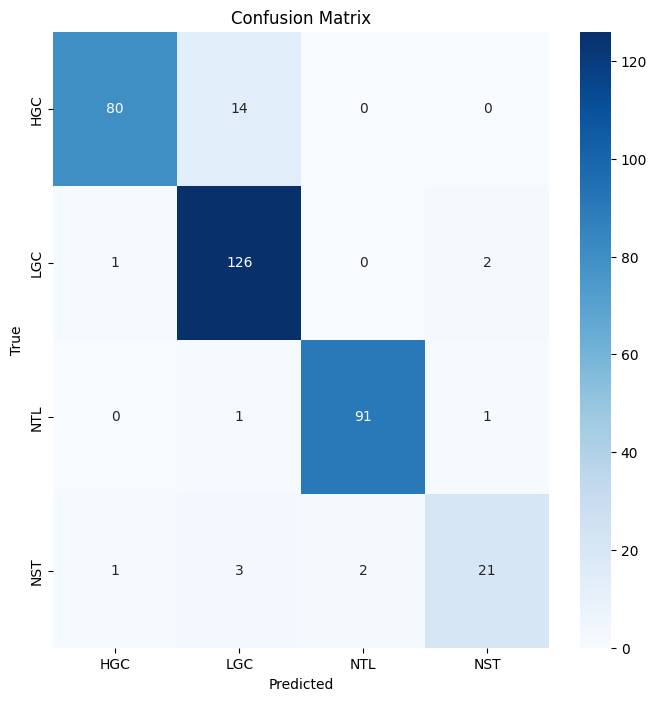

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix
# Confusion Matrix'i görselleştiren fonksiyon
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
# Modeli değerlendiren ve sonuçları görselleştiren fonksiyon
def evaluate_model_with_visualization(best_model, X_test, y_test_categorical):
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test_categorical)
    # Modelin tahminlerini al
    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_categorical, axis=1)
     # Metrikleri hesapla
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    # Confusion Matrix hesapla
    cm = confusion_matrix(y_true, y_pred_classes)
    # True Positives, False Positives, False Negatives, True Negatives hesapla
    true_positives = np.diag(cm)
    false_positives = np.sum(cm, axis=0) - true_positives
    false_negatives = np.sum(cm, axis=1) - true_positives
    true_negatives = np.sum(cm) - (true_positives + false_positives + false_negatives)
    # Sensitivity ve Specificity hesapla
    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)
    # Sonuçları yazdır
    print(f"Loss: {test_loss}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

    # Confusion Matrix Görselleştirmesi
    plot_confusion_matrix(cm, classes=["HGC", "LGC", "NTL", "NST"])

# Kullanım örneği
evaluate_model_with_visualization(best_model, X_test, y_test_categorical)


1/1 [==============================] - 0s 20ms/step
Tahmin doğru! Gerçek etiket: LGC, Tahmin edilen etiket: LGC
1/1 [==============================] - 0s 19ms/step
Tahmin doğru! Gerçek etiket: LGC, Tahmin edilen etiket: LGC
1/1 [==============================] - 0s 18ms/step
Tahmin doğru! Gerçek etiket: LGC, Tahmin edilen etiket: LGC
1/1 [==============================] - 0s 18ms/step
Tahmin doğru! Gerçek etiket: LGC, Tahmin edilen etiket: LGC


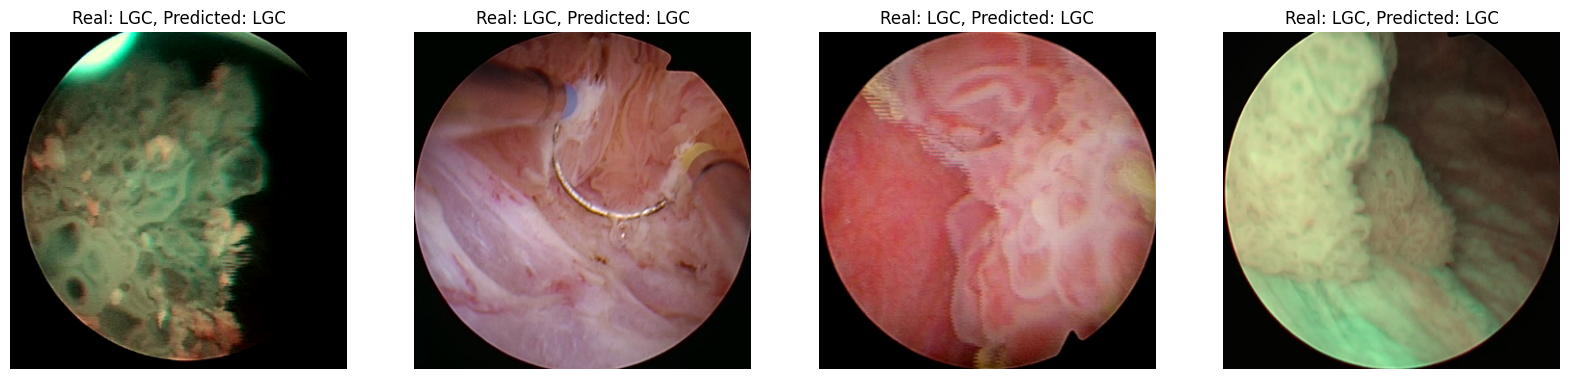

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import os
import random

# LabelEncoder oluştur
label_encoder = LabelEncoder()

# Etiketleri encode et
encoded_labels = label_encoder.fit_transform(label)

def predict_and_show_random(axs, file_names, encoded_labels, source_directory, label_encoder, num_samples=1):
    # Belirli sayıda rastgele indeks seç
    random_indices = random.sample(range(len(file_names)), num_samples)

    for i, index in enumerate(random_indices):
        file_name = file_names.iloc[index]
        encoded_label = encoded_labels[index]

        # Görüntü yolunu oluştur
        image_path = os.path.join(source_directory, file_name)

        # Görüntüyü yükle
        img = image.load_img(image_path, target_size=(200, 200))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Tahmin et
        predictions = best_model.predict(img_array)
        predicted_class = np.argmax(predictions)

        if predicted_class == encoded_label:
            print(f"Tahmin doğru! Gerçek etiket: {label_encoder.inverse_transform([encoded_label])[0]}, Tahmin edilen etiket: {label_encoder.inverse_transform([predicted_class])[0]}")
        else:
            print(f"Tahmin yanlış. Gerçek etiket: {label_encoder.inverse_transform([encoded_label])[0]}, Tahmin edilen etiket: {label_encoder.inverse_transform([predicted_class])[0]}")

        # Görüntüyü aç
        img_pil = Image.open(image_path)

        # Görüntüyü NumPy dizisine dönüştür
        image_array = np.array(img_pil)

        # Görüntüyü göster
        axs[i].imshow(image_array)
        axs[i].set_title(f"Real: {label_encoder.inverse_transform([encoded_label])[0]}, Predicted: {label_encoder.inverse_transform([predicted_class])[0]}")
        axs[i].axis('off')

# Görüntüleri yan yana sırala
num_samples = 4  # Seçilecek rastgele görüntü sayısı
fig, axs = plt.subplots(1, num_samples, figsize=(20, 5))

# Her bir görüntü için predict_and_show_random fonksiyonunu çağır
predict_and_show_random(axs, file_names, encoded_labels, source_directory, label_encoder, num_samples)

plt.show()


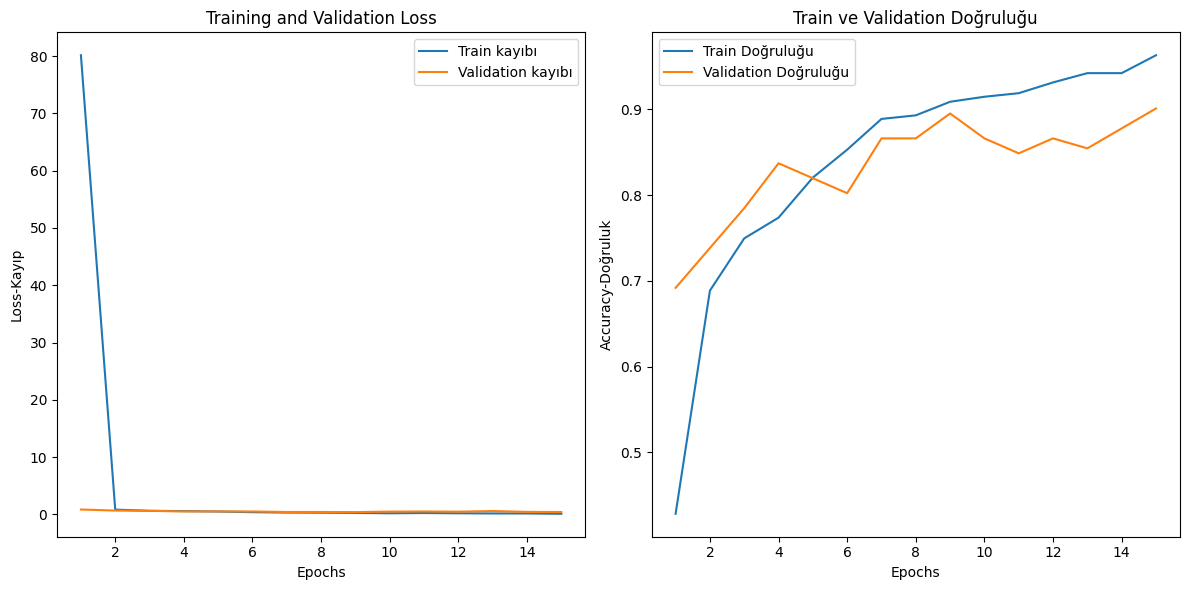

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıp değerlerini al
train_loss = history_CNN.history['loss']
val_loss = history_CNN.history['val_loss']

# Eğitim ve doğrulama doğruluk değerlerini al
train_acc = history_CNN.history['accuracy']
val_acc = history_CNN.history['val_accuracy']

# Grafik oluştur
plt.figure(figsize=(12, 6))

# Kayıp değerleri için grafik
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train kayıbı')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation kayıbı')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss-Kayıp')
plt.legend()

# Doğruluk değerleri için grafik
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Doğruluğu')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Doğruluğu')
plt.title('Train ve Validation Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy-Doğruluk')
plt.legend()

# Grafikleri göster
plt.tight_layout()
plt.show()


# **LeNet**

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import SGD
from keras.utils import to_categorical
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten

# Modeli oluştur
input_shape = (200, 200, 3) 
num_classes = 4  

def build_lenet_model(hp):
  model = Sequential()
  model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(120, activation='relu'))
  model.add(Dense(84, activation='relu'))
  model.add(Dense(4, activation='softmax'))

  # Modeli derle
  optimizer = Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

# Etiketleri kategorik biçime dönüştür
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# One-Hot Encoding işlemi
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

tuner = RandomSearch(
    build_lenet_model,
    objective='val_accuracy',
    max_trials=5,  
    directory='random_search',
    project_name='my_project'
)

tuner.search(X_train, y_train_categorical, epochs=15, validation_data=(X_val, y_val_categorical))

# En iyi hiperparametreleri al
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hp}")

# En iyi modeli oluştur
best_model = tuner.hypermodel.build(best_hp)

# Modeli eğit
history_model = best_model.fit(X_train, y_train_categorical, epochs=15, validation_data=(X_val, y_val_categorical))

# Modeli değerlendir
test_loss, test_acc = best_model.evaluate(X_test, y_test_categorical)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

<ipython-input-6-b3c755250170>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Reloading Tuner from random_search/my_project/tuner0.json
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7da782467730>
Epoch 1/15
38/38 [==============================] - 5s 36ms/step - loss: 120.6469 - accuracy: 0.4725 - val_loss: 1.2242 - val_accuracy: 0.6686
Epoch 2/15
38/38 [==============================] - 1s 19ms/step - loss: 0.6349 - accuracy: 0.8030 - val_loss: 0.5740 - val_accuracy: 0.8314
Epoch 3/15
38/38 [==============================] - 1s 19ms/step - loss: 0.2631 - accuracy: 0.9316 - val_loss: 0.4113 - val_accuracy: 0.8430
Epoch 4/15
38/38 [==============================] - 1s 19ms/step - loss: 0.1328 - accuracy: 0.9674 - val_loss: 0.3585 - val_accuracy: 0.8953
Epoch 5/15
38/38 [==============================] - 1s 19ms/step - loss: 0.0836 - accuracy: 0.9841 - val_loss: 0.3506 - val_accuracy: 0.8953
Epoch 6/15
38/38 [==============================] - 1s 19ms/step - loss: 0.0544 - accuracy: 0.9925 - val_loss: 0.32

In [15]:
from tensorflow.keras.models import save_model

# Modelinizi kaydedin
best_model.save(project_directory+"\lenet_model.h5")

c:\Users\oztrk\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 1s 36ms/step
Loss: 0.3831985294818878
Accuracy: 0.9181286549707602
Precision: 0.9179071924596752
Recall: 0.9181286549707602
F1-score: 0.9173030983228202
Sensitivity: [0.87234043 0.95348837 0.9673913  0.74074074]
Specificity: [0.97177419 0.9342723  0.988      0.98730159]


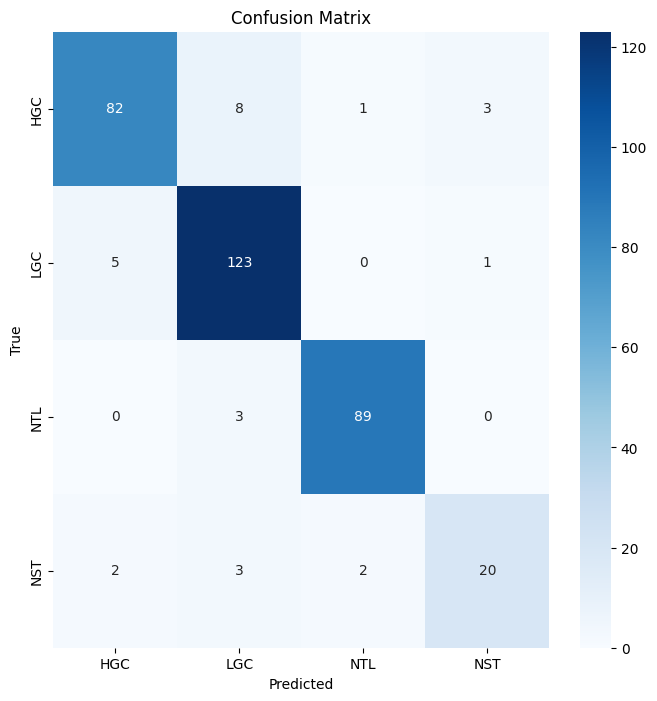

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix
# Confusion Matrix'i görselleştiren fonksiyon
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
# Modeli değerlendiren ve sonuçları görselleştiren fonksiyon
def evaluate_model(lenet_model, X_test, y_test_categorical):
    # Test seti üzerinde modeli değerlendir
    test_loss, test_accuracy = lenet_model.evaluate(X_test, y_test_categorical)
    # Modelin tahminlerini al
    y_pred = lenet_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_categorical, axis=1)

    # Metrikleri hesapla
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    # Confusion Matrix hesapla
    cm = confusion_matrix(y_true, y_pred_classes)

    # True Positives, False Positives, False Negatives, True Negatives hesapla
    true_positives = np.diag(cm)
    false_positives = np.sum(cm, axis=0) - true_positives
    false_negatives = np.sum(cm, axis=1) - true_positives
    true_negatives = np.sum(cm) - (true_positives + false_positives + false_negatives)
    # Sensitivity ve Specificity hesapla
    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)
   # Sonuçları yazdır
    print(f"Loss: {test_loss}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    # Confusion Matrix Görselleştirmesi
    plot_confusion_matrix(cm, classes=["HGC", "LGC", "NTL", "NST"])
# Kullanım örneği   
evaluate_model(lenet_model, X_test, y_test_categorical)


1/1 [==============================] - 0s 165ms/step
Tahmin doğru! Gerçek etiket: NST, Tahmin edilen etiket: NST
1/1 [==============================] - 0s 58ms/step
Tahmin doğru! Gerçek etiket: HGC, Tahmin edilen etiket: HGC
1/1 [==============================] - 0s 33ms/step
Tahmin doğru! Gerçek etiket: HGC, Tahmin edilen etiket: HGC
1/1 [==============================] - 0s 32ms/step
Tahmin doğru! Gerçek etiket: HGC, Tahmin edilen etiket: HGC


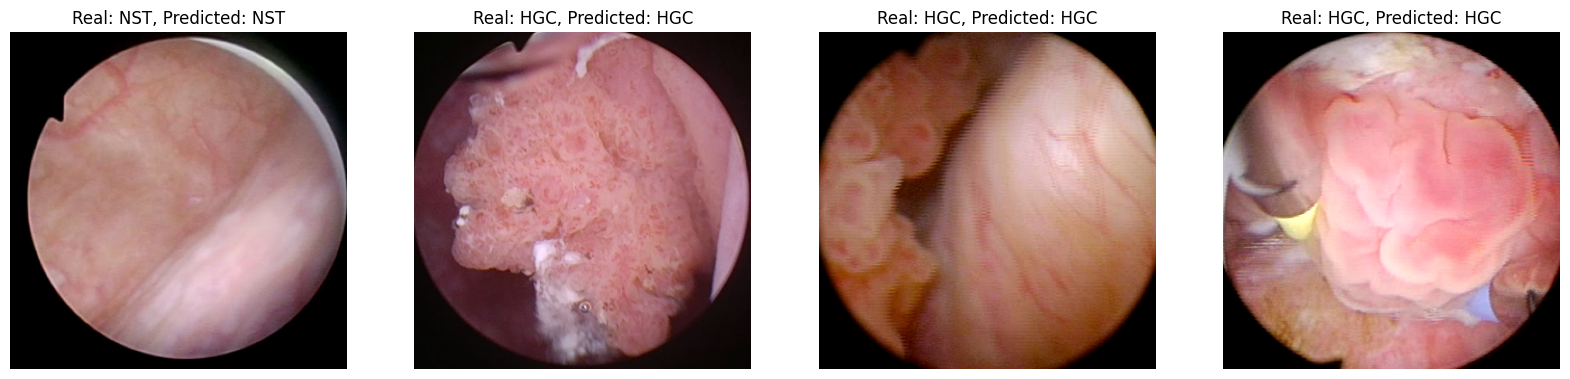

In [20]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import os
import random

# LabelEncoder oluştur
label_encoder = LabelEncoder()

# Etiketleri encode et
encoded_labels = label_encoder.fit_transform(label)

def predict_and_show_random(axs, file_names, encoded_labels, source_directory, label_encoder, num_samples=1):
    # Belirli sayıda rastgele indeks seç
    random_indices = random.sample(range(len(file_names)), num_samples)

    for i, index in enumerate(random_indices):
        file_name = file_names.iloc[index]
        encoded_label = encoded_labels[index]

        # Görüntü yolunu oluştur
        image_path = os.path.join(source_directory, file_name)

        # Görüntüyü yükle
        img = image.load_img(image_path, target_size=(200, 200))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Tahmin et
        predictions = lenet_model.predict(img_array)
        predicted_class = np.argmax(predictions)

        if predicted_class == encoded_label:
            print(f"Tahmin doğru! Gerçek etiket: {label_encoder.inverse_transform([encoded_label])[0]}, Tahmin edilen etiket: {label_encoder.inverse_transform([predicted_class])[0]}")
        else:
            print(f"Tahmin yanlış. Gerçek etiket: {label_encoder.inverse_transform([encoded_label])[0]}, Tahmin edilen etiket: {label_encoder.inverse_transform([predicted_class])[0]}")

        # Görüntüyü aç
        img_pil = Image.open(image_path)

        # Görüntüyü NumPy dizisine dönüştür
        image_array = np.array(img_pil)

        # Görüntüyü göster
        axs[i].imshow(image_array)
        axs[i].set_title(f"Real: {label_encoder.inverse_transform([encoded_label])[0]}, Predicted: {label_encoder.inverse_transform([predicted_class])[0]}")
        axs[i].axis('off')

# Görüntüleri yan yana sırala
num_samples = 4  # Seçilecek rastgele görüntü sayısı
fig, axs = plt.subplots(1, num_samples, figsize=(20, 5))

# Her bir görüntü için predict_and_show_random fonksiyonunu çağır
predict_and_show_random(axs, file_names, encoded_labels, source_directory, label_encoder, num_samples)

plt.show()


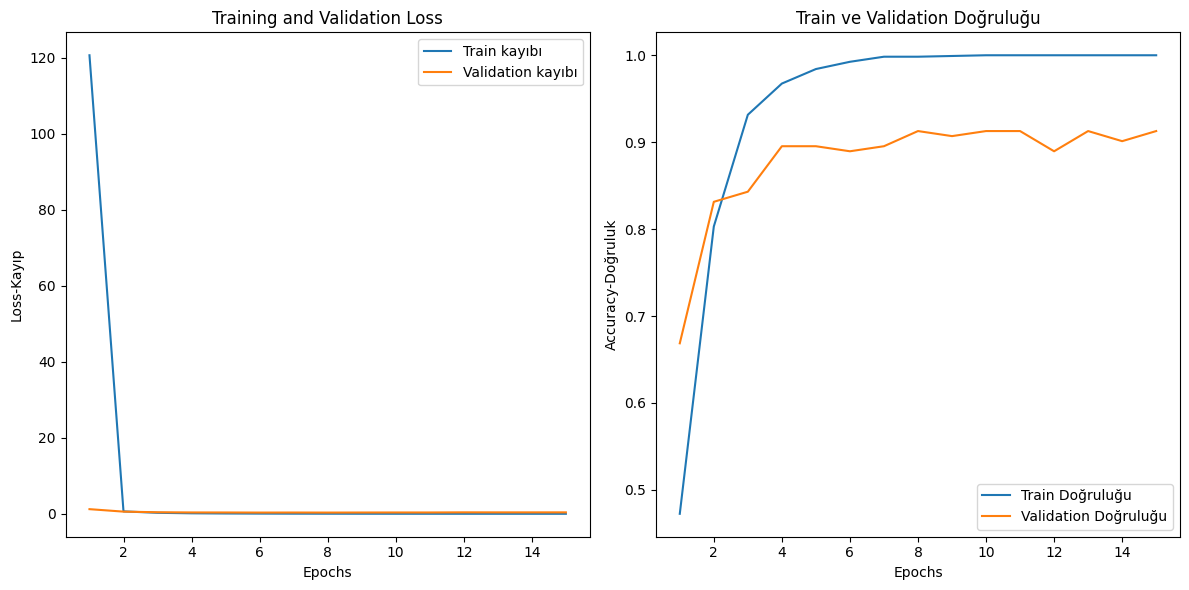

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıp değerlerini al
train_loss = history_model.history['loss']
val_loss = history_model.history['val_loss']

# Eğitim ve doğrulama doğruluk değerlerini al
train_acc = history_model.history['accuracy']
val_acc = history_model.history['val_accuracy']

# Grafik oluştur
plt.figure(figsize=(12, 6))

# Kayıp değerleri için grafik
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train kayıbı')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation kayıbı')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss-Kayıp')
plt.legend()

# Doğruluk değerleri için grafik
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Doğruluğu')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Doğruluğu')
plt.title('Train ve Validation Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy-Doğruluk')
plt.legend()

# Grafikleri göster
plt.tight_layout()
plt.show()


# **GoogLenet**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

input_shape = (200, 200, 3)

def build_model(hp):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'),
        layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        layers.Dense(4, activation='softmax')
    ])

    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='random_search',
    project_name='custom_model_project'
)

tuner.search(X_train, y_train_categorical, epochs=15, validation_data=(X_val, y_val_categorical))

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hp}")

best_model_GoogLenet = tuner.hypermodel.build(best_hp)

history_GoogLenet = best_model_GoogLenet.fit(X_train, y_train_categorical, epochs=15, validation_data=(X_val, y_val_categorical))

test_loss_GoogLenet, test_acc_GoogLenet = best_model_GoogLenet.evaluate(X_test, y_test_categorical)
print(f'Test Loss (GoogLenet): {test_loss_inception}, Test Accuracy (GoogLenet): {test_acc_inception}')


Trial 5 Complete [00h 00m 27s]
val_accuracy: 0.9011628031730652

Best val_accuracy So Far: 0.9360465407371521
Total elapsed time: 00h 02m 27s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7b2095bfe6e0>
Epoch 1/15
38/38 [==============================] - 3s 50ms/step - loss: 45.7216 - accuracy: 0.5501 - val_loss: 0.7402 - val_accuracy: 0.7151
Epoch 2/15
38/38 [==============================] - 2s 41ms/step - loss: 0.5025 - accuracy: 0.8331 - val_loss: 0.4203 - val_accuracy: 0.8488
Epoch 3/15
38/38 [==============================] - 2s 41ms/step - loss: 0.3247 - accuracy: 0.8973 - val_loss: 0.3058 - val_accuracy: 0.8779
Epoch 4/15
38/38 [==============================] - 2s 42ms/step - loss: 0.2407 - accuracy: 0.9240 - val_loss: 0.2534 - val_accuracy: 0.9302
Epoch 5/15
38/38 [==============================] - 2s 42ms/step - loss: 0.1932 - accuracy: 0.9382 - val_loss: 0.2709 - val_accuracy: 0.9012
Epoch 6/15
38/38 [==============

In [ ]:
from tensorflow.keras.models import save_model
# Modelinizi kaydedin
best_model_GoogLenet.save(project_directory+"\model\inception_model.h5")

11/11 [==============================] - 0s 14ms/step
Loss: 0.16128107905387878
Accuracy: 0.9475218658892128
Precision: 0.9481079472056811
Recall: 0.9475218658892128
F1-score: 0.9467895857129789
Sensitivity: [0.91489362 0.98449612 0.97849462 0.77777778]
Specificity: [0.98795181 0.94859813 0.992      0.99367089]


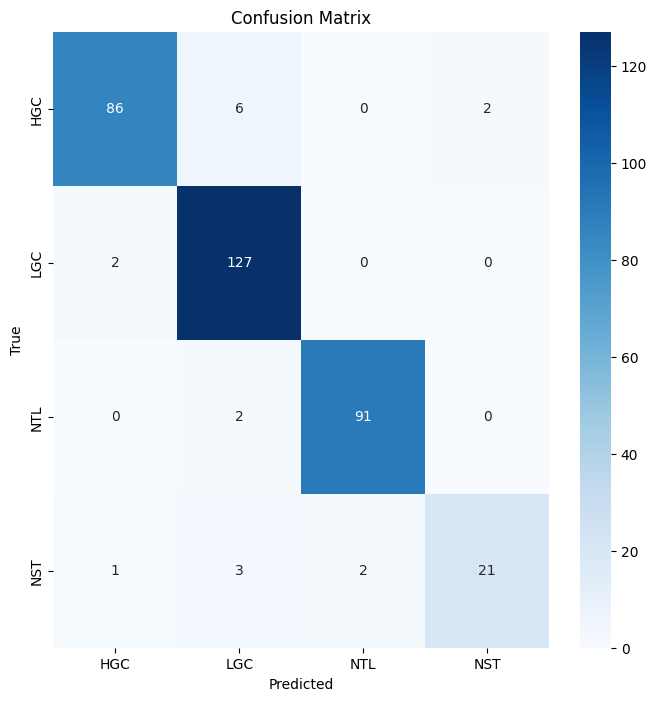

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix


def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def evaluate_model(best_model_GoogLenet, X_test, y_test_categorical):
    test_loss, test_accuracy = best_model_GoogLenet.evaluate(X_test, y_test_categorical)
    
    y_pred = best_model_GoogLenet.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_categorical, axis=1)

    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    cm = confusion_matrix(y_true, y_pred_classes)

    true_positives = np.diag(cm)
    false_positives = np.sum(cm, axis=0) - true_positives
    false_negatives = np.sum(cm, axis=1) - true_positives
    true_negatives = np.sum(cm) - (true_positives + false_positives + false_negatives)

    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    print(f"Loss: {test_loss}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

    plot_confusion_matrix(cm, classes=["HGC", "LGC", "NTL", "NST"])

evaluate_model(best_model_GoogLenet, X_test, y_test_categorical)


1/1 [==============================] - 0s 189ms/step
Tahmin doğru! Gerçek etiket: LGC, Tahmin edilen etiket: LGC
1/1 [==============================] - 0s 18ms/step
Tahmin doğru! Gerçek etiket: NST, Tahmin edilen etiket: NST
1/1 [==============================] - 0s 18ms/step
Tahmin yanlış. Gerçek etiket: HGC, Tahmin edilen etiket: LGC
1/1 [==============================] - 0s 18ms/step
Tahmin doğru! Gerçek etiket: NST, Tahmin edilen etiket: NST


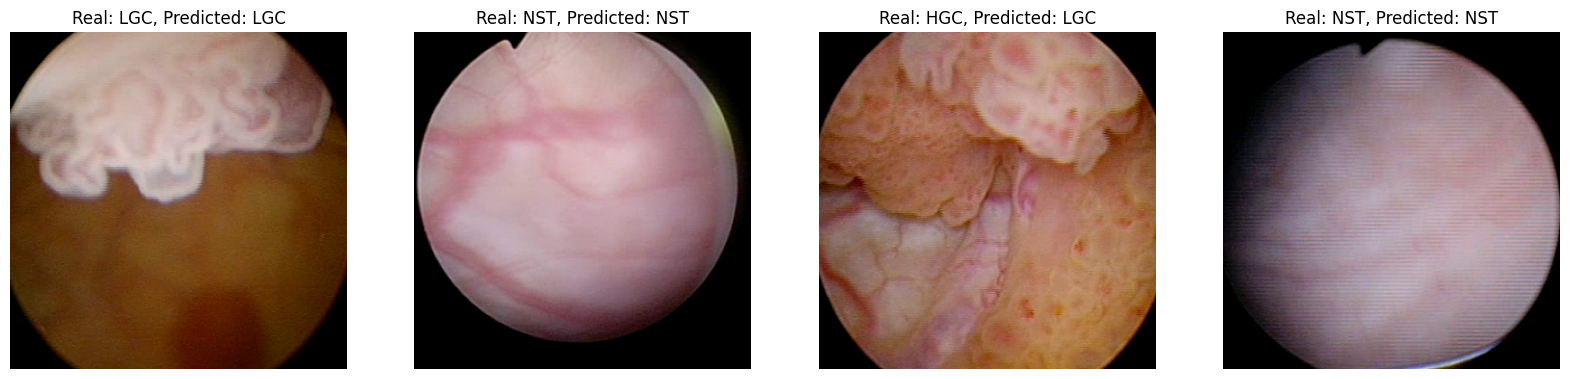

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import os
import random

label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(label)

def predict_and_show_random(axs, file_names, encoded_labels, source_directory, label_encoder, num_samples=1):
    random_indices = random.sample(range(len(file_names)), num_samples)

    for i, index in enumerate(random_indices):
        file_name = file_names.iloc[index]
        encoded_label = encoded_labels[index]

        image_path = os.path.join(source_directory, file_name)
        img = image.load_img(image_path, target_size=(200, 200))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        predictions = best_model_GoogLenet.predict(img_array)
        predicted_class = np.argmax(predictions)

        if predicted_class == encoded_label:
            print(f"Tahmin doğru! Gerçek etiket: {label_encoder.inverse_transform([encoded_label])[0]}, Tahmin edilen etiket: {label_encoder.inverse_transform([predicted_class])[0]}")
        else:
            print(f"Tahmin yanlış. Gerçek etiket: {label_encoder.inverse_transform([encoded_label])[0]}, Tahmin edilen etiket: {label_encoder.inverse_transform([predicted_class])[0]}")

        img_pil = Image.open(image_path)
        image_array = np.array(img_pil)

        axs[i].imshow(image_array)
        axs[i].set_title(f"Real: {label_encoder.inverse_transform([encoded_label])[0]}, Predicted: {label_encoder.inverse_transform([predicted_class])[0]}")
        axs[i].axis('off')

num_samples = 4  
fig, axs = plt.subplots(1, num_samples, figsize=(20, 5))

predict_and_show_random(axs, file_names, encoded_labels, source_directory, label_encoder, num_samples)

plt.show()


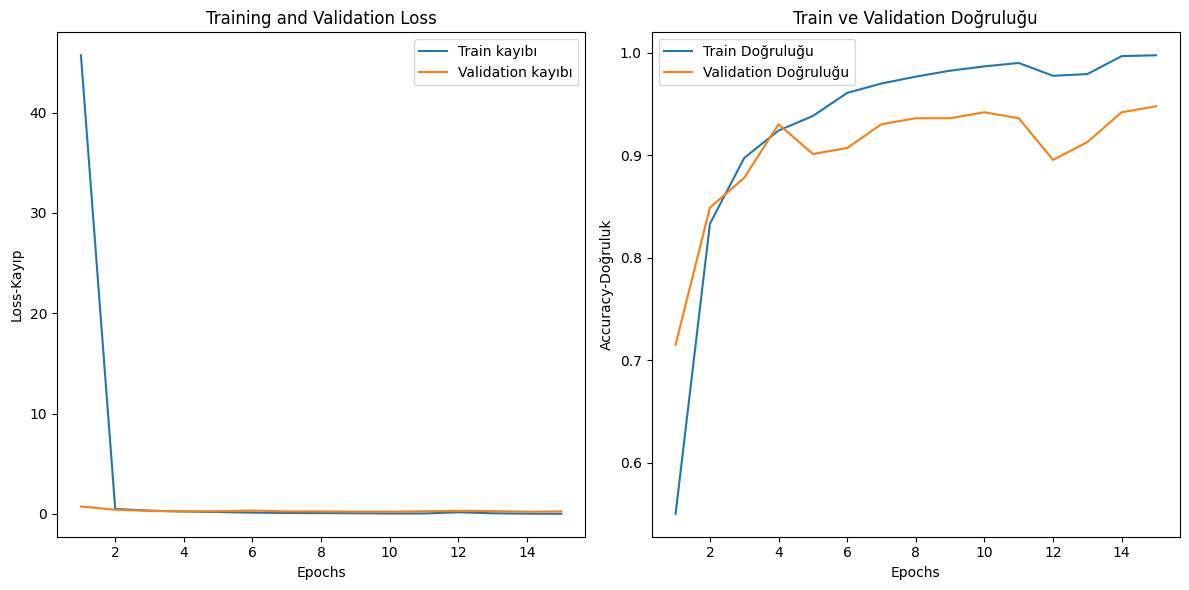

In [ ]:
import matplotlib.pyplot as plt

train_loss = history_GoogLenet.history['loss']
val_loss = history_GoogLenet.history['val_loss']

train_acc = history_GoogLenet.history['accuracy']
val_acc = history_GoogLenet.history['val_accuracy']

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train kayıbı')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation kayıbı')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss-Kayıp')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Doğruluğu')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Doğruluğu')
plt.title('Train ve Validation Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy-Doğruluk')
plt.legend()


plt.tight_layout()
plt.show()


# **DenseNet121**

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

def build_densenet_model(hp):
    input_layer = Input(shape=(200, 200, 3))
    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_layer)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=hp.Int('units_1', min_value=512, max_value=1024, step=128, default=1024),
              activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dense(units=hp.Int('units_2', min_value=256, max_value=512, step=64, default=512),
              activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dense(units=hp.Int('units_3', min_value=128, max_value=256, step=32, default=256),
              activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    optimizer_densenet = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))
    model.compile(optimizer=optimizer_densenet, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_categorical = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

densenet_tuner = RandomSearch(
    build_densenet_model,
    objective='val_accuracy',
    max_trials=5,
    directory='densenet_random_search',
    project_name='densenet_project'
)

densenet_tuner.search(X_train, y_train_categorical, epochs=15, validation_data=(X_val, y_val_categorical))

best_densenet_hp = densenet_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters for DenseNet121 Model: {best_densenet_hp}")

best_densenet_model = densenet_tuner.hypermodel.build(best_densenet_hp)

history_densenet_model=best_densenet_model.fit(X_train, y_train_categorical, epochs=15, validation_data=(X_val, y_val_categorical))

test_loss_densenet, test_acc_densenet = best_densenet_model.evaluate(X_test, y_test_categorical)
print(f'Test Loss (DenseNet121): {test_loss_densenet}, Test Accuracy (DenseNet121): {test_acc_densenet}')


Reloading Tuner from densenet_random_search/densenet_project/tuner0.json
Best Hyperparameters for DenseNet121 Model: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7b209616c790>
Epoch 1/15
38/38 [==============================] - 60s 341ms/step - loss: 3.1051 - accuracy: 0.6068 - val_loss: 3.1478 - val_accuracy: 0.5000
Epoch 2/15
38/38 [==============================] - 11s 288ms/step - loss: 2.5801 - accuracy: 0.8823 - val_loss: 2.7460 - val_accuracy: 0.7558
Epoch 3/15
38/38 [==============================] - 11s 291ms/step - loss: 2.2997 - accuracy: 0.9382 - val_loss: 2.4414 - val_accuracy: 0.8372
Epoch 4/15
38/38 [==============================] - 11s 290ms/step - loss: 2.1452 - accuracy: 0.9766 - val_loss: 2.2473 - val_accuracy: 0.9186
Epoch 5/15
38/38 [==============================] - 11s 287ms/step - loss: 2.0499 - accuracy: 0.9908 - val_loss: 2.1469 - val_accuracy: 0.9535
Epoch 6/15
38/38 [==============================] - 11s 285ms/step - l

In [ ]:
from tensorflow.keras.models import save_model

# Modelinizi kaydedin
best_model.save(project_directory+"\densenet_model.h5")

11/11 [==============================] - 2s 75ms/step
Loss: 1.831058382987976
Accuracy: 0.967930029154519
Precision: 0.9679114601054545
Recall: 0.967930029154519
F1-score: 0.967415433938733
Sensitivity: [0.9787234  0.98449612 0.97849462 0.81481481]
Specificity: [0.98393574 0.99065421 0.984      0.99683544]


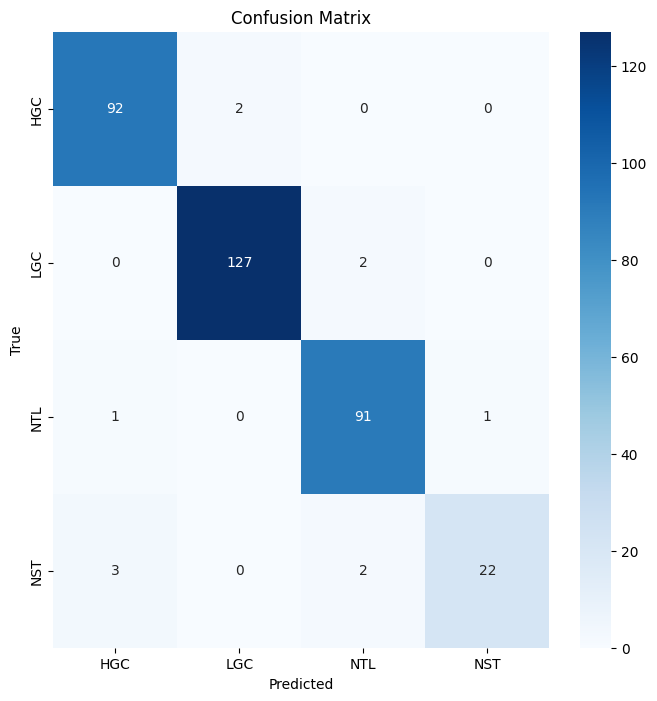

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix


def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def evaluate_model(best_densenet_model, X_test, y_test_categorical):
    test_loss, test_accuracy = best_densenet_model.evaluate(X_test, y_test_categorical)

    y_pred = best_densenet_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_categorical, axis=1)

    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    cm = confusion_matrix(y_true, y_pred_classes)

    true_positives = np.diag(cm)
    false_positives = np.sum(cm, axis=0) - true_positives
    false_negatives = np.sum(cm, axis=1) - true_positives
    true_negatives = np.sum(cm) - (true_positives + false_positives + false_negatives)

    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    print(f"Loss: {test_loss}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

    plot_confusion_matrix(cm, classes=["HGC", "LGC", "NTL", "NST"])

evaluate_model(best_densenet_model, X_test, y_test_categorical)


1/1 [==============================] - 0s 34ms/step
Tahmin doğru! Gerçek etiket: NST, Tahmin edilen etiket: NST
1/1 [==============================] - 0s 34ms/step
Tahmin doğru! Gerçek etiket: NST, Tahmin edilen etiket: NST
1/1 [==============================] - 0s 32ms/step
Tahmin doğru! Gerçek etiket: LGC, Tahmin edilen etiket: LGC
1/1 [==============================] - 0s 35ms/step
Tahmin doğru! Gerçek etiket: NST, Tahmin edilen etiket: NST


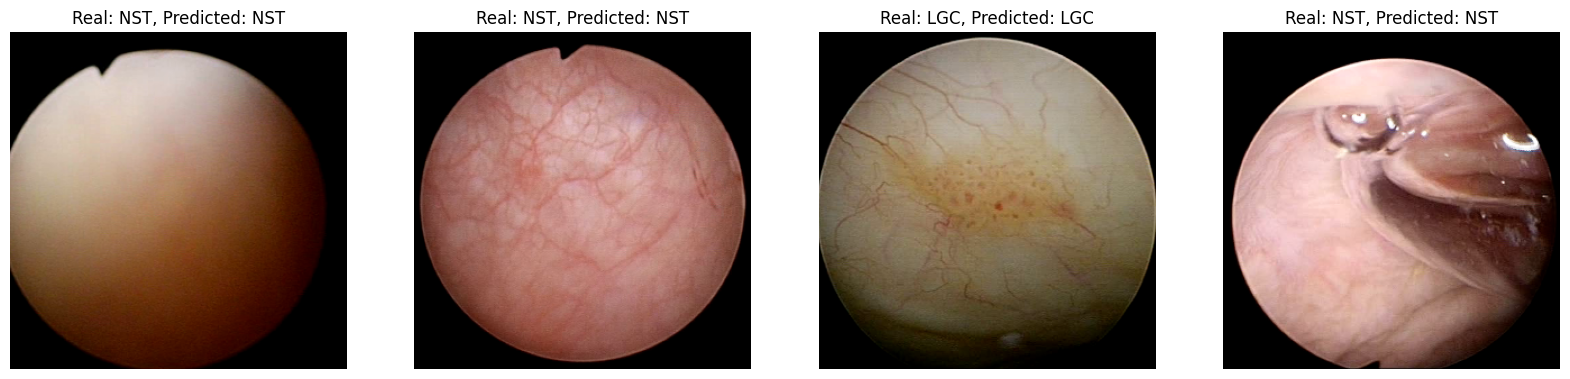

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import os
import random

label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(label)

def predict_and_show_random(axs, file_names, encoded_labels, source_directory, label_encoder, num_samples=1):
    random_indices = random.sample(range(len(file_names)), num_samples)

    for i, index in enumerate(random_indices):
        file_name = file_names.iloc[index]
        encoded_label = encoded_labels[index]

        image_path = os.path.join(source_directory, file_name)

        img = image.load_img(image_path, target_size=(200, 200))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        predictions = best_densenet_model.predict(img_array)
        predicted_class = np.argmax(predictions)

        if predicted_class == encoded_label:
            print(f"Tahmin doğru! Gerçek etiket: {label_encoder.inverse_transform([encoded_label])[0]}, Tahmin edilen etiket: {label_encoder.inverse_transform([predicted_class])[0]}")
        else:
            print(f"Tahmin yanlış. Gerçek etiket: {label_encoder.inverse_transform([encoded_label])[0]}, Tahmin edilen etiket: {label_encoder.inverse_transform([predicted_class])[0]}")

        img_pil = Image.open(image_path)
        image_array = np.array(img_pil)
        axs[i].imshow(image_array)
        axs[i].set_title(f"Real: {label_encoder.inverse_transform([encoded_label])[0]}, Predicted: {label_encoder.inverse_transform([predicted_class])[0]}")
        axs[i].axis('off')

num_samples = 4  
fig, axs = plt.subplots(1, num_samples, figsize=(20, 5))

predict_and_show_random(axs, file_names, encoded_labels, source_directory, label_encoder, num_samples)

plt.show()


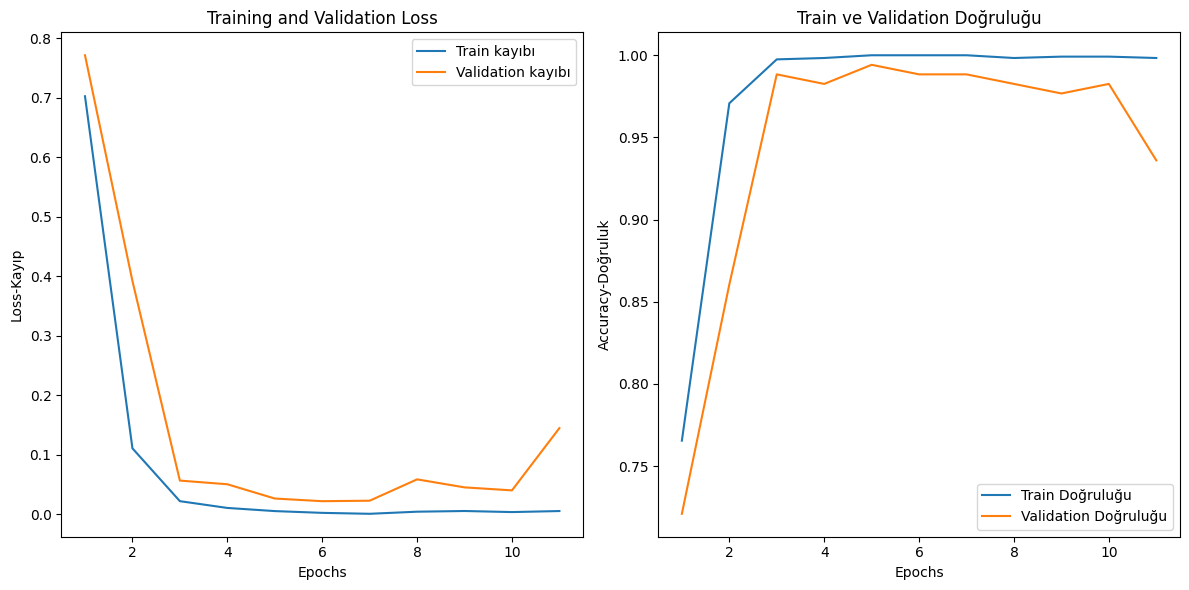

In [ ]:
import matplotlib.pyplot as plt

train_loss = history_densenet_model.history['loss']
val_loss = history_densenet_model.history['val_loss']

train_acc = history_densenet_model.history['accuracy']
val_acc = history_densenet_model.history['val_accuracy']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train kayıbı')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation kayıbı')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss-Kayıp')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Doğruluğu')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Doğruluğu')
plt.title('Train ve Validation Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy-Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()


# **EfficientNetB0**

In [ ]:

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

num_classes = 4 

def build_efficientnet_model(hp):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    dense_units = hp.Int('dense_units', min_value=256, max_value=1024, step=256)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)

    x = Dense(dense_units, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Sequential([base_model, GlobalAveragePooling2D(), Dense(dense_units, activation='relu'), Dense(512, activation='relu'), Dense(256, activation='relu'), Dense(num_classes, activation='softmax')])

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

tuner = RandomSearch(
    build_efficientnet_model,
    objective='val_accuracy',
    max_trials=5,
    directory='random_search',
    project_name='efficientnet_project'
)

tuner.search(X_train, y_train_categorical, epochs=15, validation_data=(X_val, y_val_categorical))

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hp}")

best_model = tuner.hypermodel.build(best_hp)

history_efficientnet_model = best_model.fit(X_train, y_train_categorical, epochs=15, validation_data=(X_val, y_val_categorical))

test_loss, test_acc = best_model.evaluate(X_test, y_test_categorical)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')


Reloading Tuner from random_search/efficientnet_project/tuner0.json
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7b177ec2d030>
Epoch 1/15
38/38 [==============================] - 41s 275ms/step - loss: 0.9443 - accuracy: 0.6578 - val_loss: 1.6864 - val_accuracy: 0.3372
Epoch 2/15
38/38 [==============================] - 9s 232ms/step - loss: 0.2940 - accuracy: 0.8973 - val_loss: 1.0499 - val_accuracy: 0.6860
Epoch 3/15
38/38 [==============================] - 9s 230ms/step - loss: 0.1176 - accuracy: 0.9750 - val_loss: 0.3923 - val_accuracy: 0.8779
Epoch 4/15
38/38 [==============================] - 9s 229ms/step - loss: 0.0496 - accuracy: 0.9908 - val_loss: 0.1225 - val_accuracy: 0.9593
Epoch 5/15
38/38 [==============================] - 9s 228ms/step - loss: 0.0228 - accuracy: 0.9958 - val_loss: 0.0800 - val_accuracy: 0.9709
Epoch 6/15
38/38 [==============================] - 9s 227ms/step - loss: 0.0103 - accuracy: 0.9967 -

In [ ]:
from tensorflow.keras.models import save_model

# Modelinizi kaydedin
best_model.save(project_directory+"\EfficientNetB0_model.h5")

11/11 [==============================] - 2s 53ms/step
Loss: 0.071808360517025
Accuracy: 0.9854227405247813
Precision: 0.985436244685751
Recall: 0.9854227405247813
F1-score: 0.9854162394035487
Confusion Matrix:
 [[ 92   2   0   0]
 [  0 128   1   0]
 [  0   0  92   1]
 [  1   0   0  26]]
Sensitivity: [0.9787234  0.99224806 0.98924731 0.96296296]
Specificity: [0.99598394 0.99065421 0.996      0.99683544]


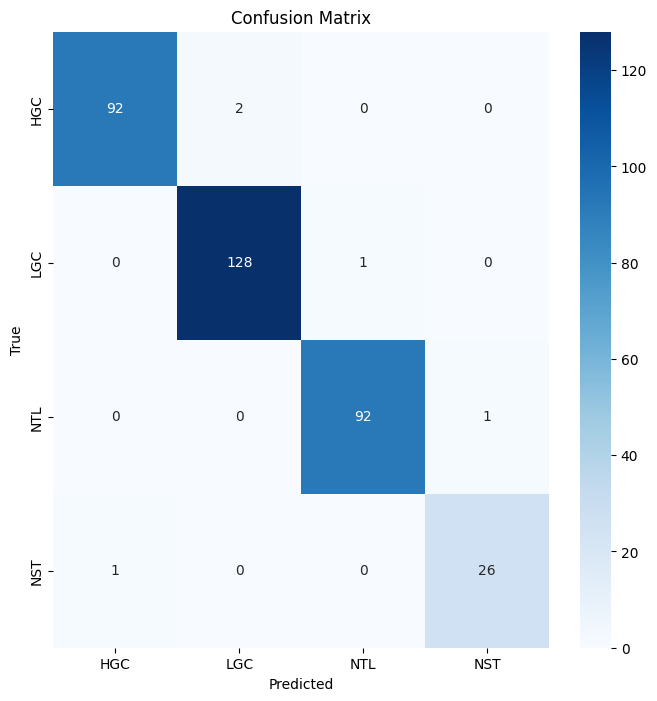

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def evaluate_model_with_visualization(best_model, X_test, y_test_categorical):
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test_categorical)

    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_categorical, axis=1)

    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    cm = confusion_matrix(y_true, y_pred_classes)

    true_positives = np.diag(cm)
    false_positives = np.sum(cm, axis=0) - true_positives
    false_negatives = np.sum(cm, axis=1) - true_positives
    true_negatives = np.sum(cm) - (true_positives + false_positives + false_negatives)

    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    print(f"Loss: {test_loss}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

    plot_confusion_matrix(cm, classes=["HGC", "LGC", "NTL", "NST"])

evaluate_model_with_visualization(best_model, X_test, y_test_categorical)


1/1 [==============================] - 0s 27ms/step
Tahmin doğru! Gerçek etiket: NST, Tahmin edilen etiket: NST
1/1 [==============================] - 0s 25ms/step
Tahmin doğru! Gerçek etiket: NST, Tahmin edilen etiket: NST
1/1 [==============================] - 0s 26ms/step
Tahmin doğru! Gerçek etiket: HGC, Tahmin edilen etiket: HGC
1/1 [==============================] - 0s 25ms/step
Tahmin doğru! Gerçek etiket: LGC, Tahmin edilen etiket: LGC


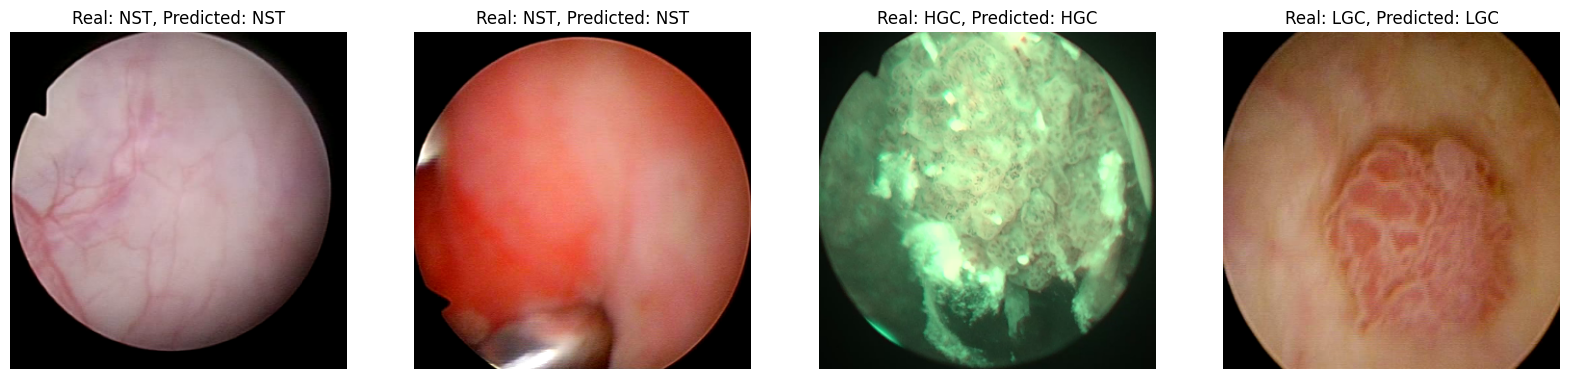

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import os
import random

label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(label)

def predict_and_show_random(axs, file_names, encoded_labels, source_directory, label_encoder, num_samples=1):
    random_indices = random.sample(range(len(file_names)), num_samples)

    for i, index in enumerate(random_indices):
        file_name = file_names.iloc[index]
        encoded_label = encoded_labels[index]

        image_path = os.path.join(source_directory, file_name)

        img = image.load_img(image_path, target_size=(200, 200))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        predictions = best_model.predict(img_array)
        predicted_class = np.argmax(predictions)

        if predicted_class == encoded_label:
            print(f"Tahmin doğru! Gerçek etiket: {label_encoder.inverse_transform([encoded_label])[0]}, Tahmin edilen etiket: {label_encoder.inverse_transform([predicted_class])[0]}")
        else:
            print(f"Tahmin yanlış. Gerçek etiket: {label_encoder.inverse_transform([encoded_label])[0]}, Tahmin edilen etiket: {label_encoder.inverse_transform([predicted_class])[0]}")

        img_pil = Image.open(image_path)
        image_array = np.array(img_pil)

        axs[i].imshow(image_array)
        axs[i].set_title(f"Real: {label_encoder.inverse_transform([encoded_label])[0]}, Predicted: {label_encoder.inverse_transform([predicted_class])[0]}")
        axs[i].axis('off')

num_samples = 4  
fig, axs = plt.subplots(1, num_samples, figsize=(20, 5))

predict_and_show_random(axs, file_names, encoded_labels, source_directory, label_encoder, num_samples)

plt.show()


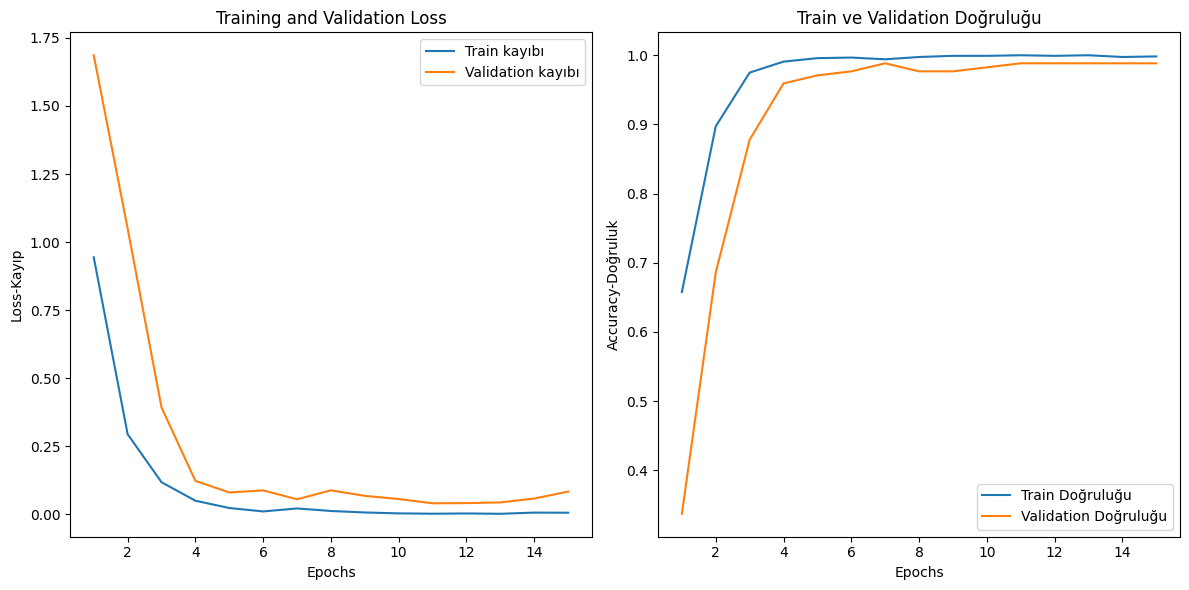

In [ ]:
import matplotlib.pyplot as plt

train_loss = history_efficientnet_model.history['loss']
val_loss = history_efficientnet_model.history['val_loss']

train_acc = history_efficientnet_model.history['accuracy']
val_acc = history_efficientnet_model.history['val_accuracy']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train kayıbı')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation kayıbı')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss-Kayıp')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Doğruluğu')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Doğruluğu')
plt.title('Train ve Validation Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Accuracy-Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()


# **ROC**

11/11 [==============================] - 1s 49ms/step


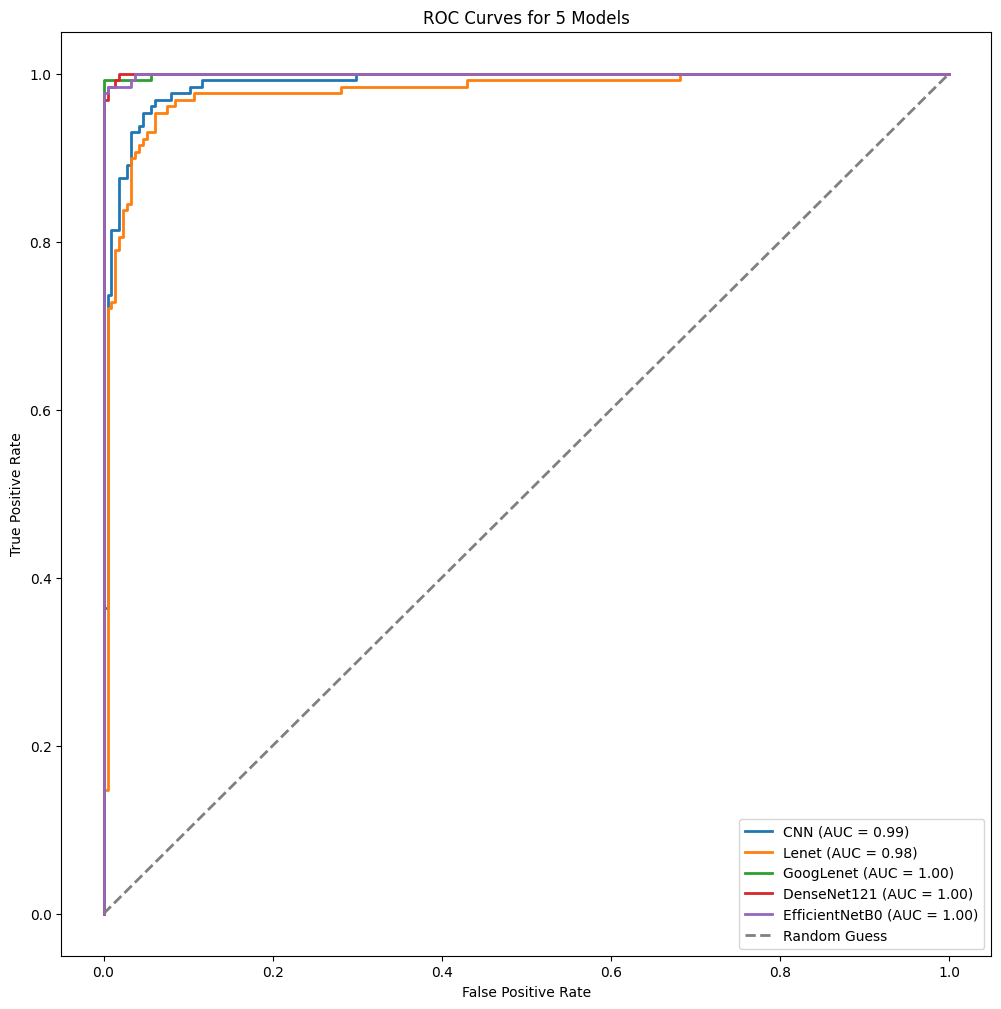

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

# Modelleri ve isimlerini listeye ekleyin
models = [cnn_model, lenet_model, GoogLenet_model, densenet_model, EfficientNetB0_model]
model_names = ['CNN', 'Lenet', 'GoogLenet', 'DenseNet121', 'EfficientNetB0']

# Her bir model için ROC eğrilerini ve AUC değerlerini hesaplayın
plt.figure(figsize=(12, 12))
for i in range(len(models)):
    y_pred_prob = models[i].predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test_categorical[:, 1], y_pred_prob[:, 1])

    # AUC değerini daha doğru hesaplamak için trapz fonksiyonunu kullanın
    roc_auc = np.trapz(tpr, fpr)

    # Her bir modelin ROC eğrisini çizdirin
    plt.plot(fpr, tpr, lw=2, label=f'{model_names[i]} (AUC = {roc_auc:.2f})')

# Rasgele tahminin ROC eğrisini çizdirin
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')

# ROC eğrilerini görselleştirme
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for 5 Models')
plt.legend(loc='lower right')
plt.show()
